In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from glob import glob
from configs import *
from tqdm import tqdm
from utils import *
import numpy as np
import matplotlib.pyplot as plt
from dataset import *
from time import time
tqdm.monitor_interval = 0
import torch
import json
import torch.nn as nn
import numpy as np
torch.manual_seed(0)
np.random.seed(0)

In [28]:
EPS = 120
LAG = 25
STOPS=1
SROUTE = [
    '403259-401851', 
    '401851-401852'
]
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device
DIFF = 1
SIND = 30
DENSE = True

Chunks (lag 25)
 [*] Segments: 90 co-avail
    * [403259-401851]: 90
    * [401851-401852]: 90


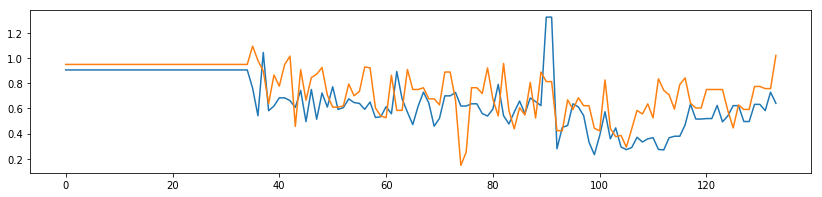

In [62]:
dset = SpotHistory(SROUTE, 'train', 16, lag=LAG, res=10) #.generator()
# evalset = SpotHistory(SROUTE, 'test', 16, lag=LAG, res=10).generator()

plt.figure(figsize=(14, 3))
plt.plot(dset[0][:, 0])
plt.plot(dset[0][:, 1])
plt.show(); plt.close()

In [9]:
from models.Linear import *
# lag = 6th timestep is predicted based on past 5 (50 mins
if DENSE:
    model = Dense(lag=LAG-1, stops=STOPS).to(device)
else:
    model = Linear(lag=LAG-1, stops=STOPS).to(device)
model.device = device
criterion, opt, sch = model.params(lr=0.001)
evaluate(evalset, model, crit=lambda _y, y: criterion(_y[:, 0], y[:, 0]).item())

Eval loss: 74.5627    


In [10]:
losses = []
eval_mse = []
eval_mape = []
from numpy.random import randint
for eii  in range(EPS):
    for bii, batch in enumerate(dset):
        model.train()
        Xs, Ys = model.format_batch(batch)
        
        outputs = model(Xs)

        opt.zero_grad()
        loss = criterion(outputs, Ys)
        loss.backward()
        losses.append(loss.item())
        opt.step()

        sys.stdout.write('[%d/%d : %d/%d] - L%.2f      \r' % (
            eii+1, EPS,
            bii+1, len(dset), 
            10**2 * loss.item()
        ))
    sys.stdout.write('\n')

    eval_mse.append(
        evaluate(
            evalset, model, 
            crit=lambda y, _y: criterion(y[:, 0], _y[:, 0]).item(), result=True))
    sys.stdout.flush()
    sch.step()

[1/120 : 288/288] - L1.34       
Eval loss: 5.7208    
[2/120 : 288/288] - L2.16       
Eval loss: 5.4721    
[3/120 : 288/288] - L0.30       
Eval loss: 5.4319    
[4/120 : 288/288] - L0.74       
Eval loss: 5.3736    
[5/120 : 288/288] - L2.59       
Eval loss: 5.3538    
[6/120 : 288/288] - L2.42       
Eval loss: 5.2813    
[7/120 : 288/288] - L2.44       
Eval loss: 5.2311    
[8/120 : 288/288] - L3.48       
Eval loss: 5.1921    
[9/120 : 288/288] - L1.35       
Eval loss: 5.1603    
[10/120 : 288/288] - L3.84       
Eval loss: 5.1379    
[11/120 : 288/288] - L4.21       
Eval loss: 5.1122    
[12/120 : 288/288] - L4.31       
Eval loss: 5.0519    
[13/120 : 288/288] - L4.37       
Eval loss: 5.0057    
[14/120 : 288/288] - L1.00       
Eval loss: 4.9933    
[15/120 : 288/288] - L1.18       
Eval loss: 4.9518    
[16/120 : 288/288] - L3.99       
Eval loss: 4.9062    
[17/120 : 288/288] - L2.12       
Eval loss: 4.9085    
[18/120 : 288/288] - L2.23       
Eval loss: 4.8843    
[

In [11]:
viewset = SpotHistory(SROUTE, 'test', 16, lag=None, res=10)
viewset = [viewset[9]]

Full history
 [*] Files found: 74
 [*] test-set size: 15
 [*] avg sequence: 111.00


IndexError: index 24 is out of bounds for dimension 1 with size 6

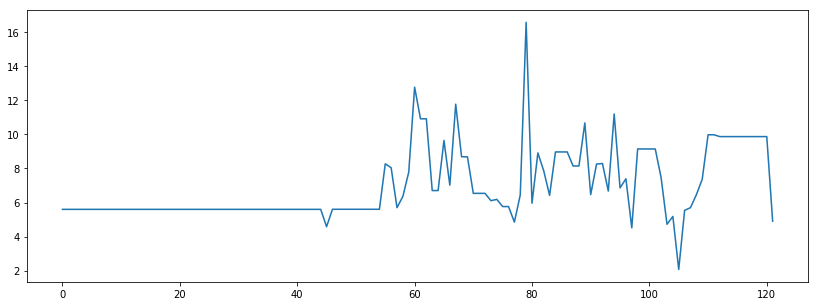

In [12]:
show_eval(viewset, model, fmax=10, diff=1)